In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
torch.cuda.is_available()

False

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [4]:
# !pip install kaggle -q
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !pip install gdown -q
# !gdown 'https://drive.google.com/uc?id=16cdd1iYelIMSGELg56gD8y9vVP2GFAfu'
# !gdown https://drive.google.com/file/d/16cdd1iYelIMSGELg56gD8y9vVP2GFAfu/view?usp=drive_link


In [5]:
# import gdown
# url = 'https://drive.google.com/uc?id=16cdd1iYelIMSGELg56gD8y9vVP2GFAfu'
# output = './data'
# gdown.download(url, output, quiet=False)


In [6]:
# import zipfile
# zip_path = "./data/cse-251-b-2025.zip"
# extract_to = "./data/"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [7]:
def getData(path):
    train_file = np.load(path+"/train.npz")
    train_data = train_file['data']
    test_file = np.load(path+"/test_input.npz")
    test_data = test_file['data']
    print(f"Training Data's shape is {train_data.shape} and Test Data's is {test_data.shape}")
    return train_data, test_data

In [8]:
trainData, testData = getData("./data")
trainData.shape, testData.shape

Training Data's shape is (10000, 50, 110, 6) and Test Data's is (2100, 50, 50, 6)


((10000, 50, 110, 6), (2100, 50, 50, 6))

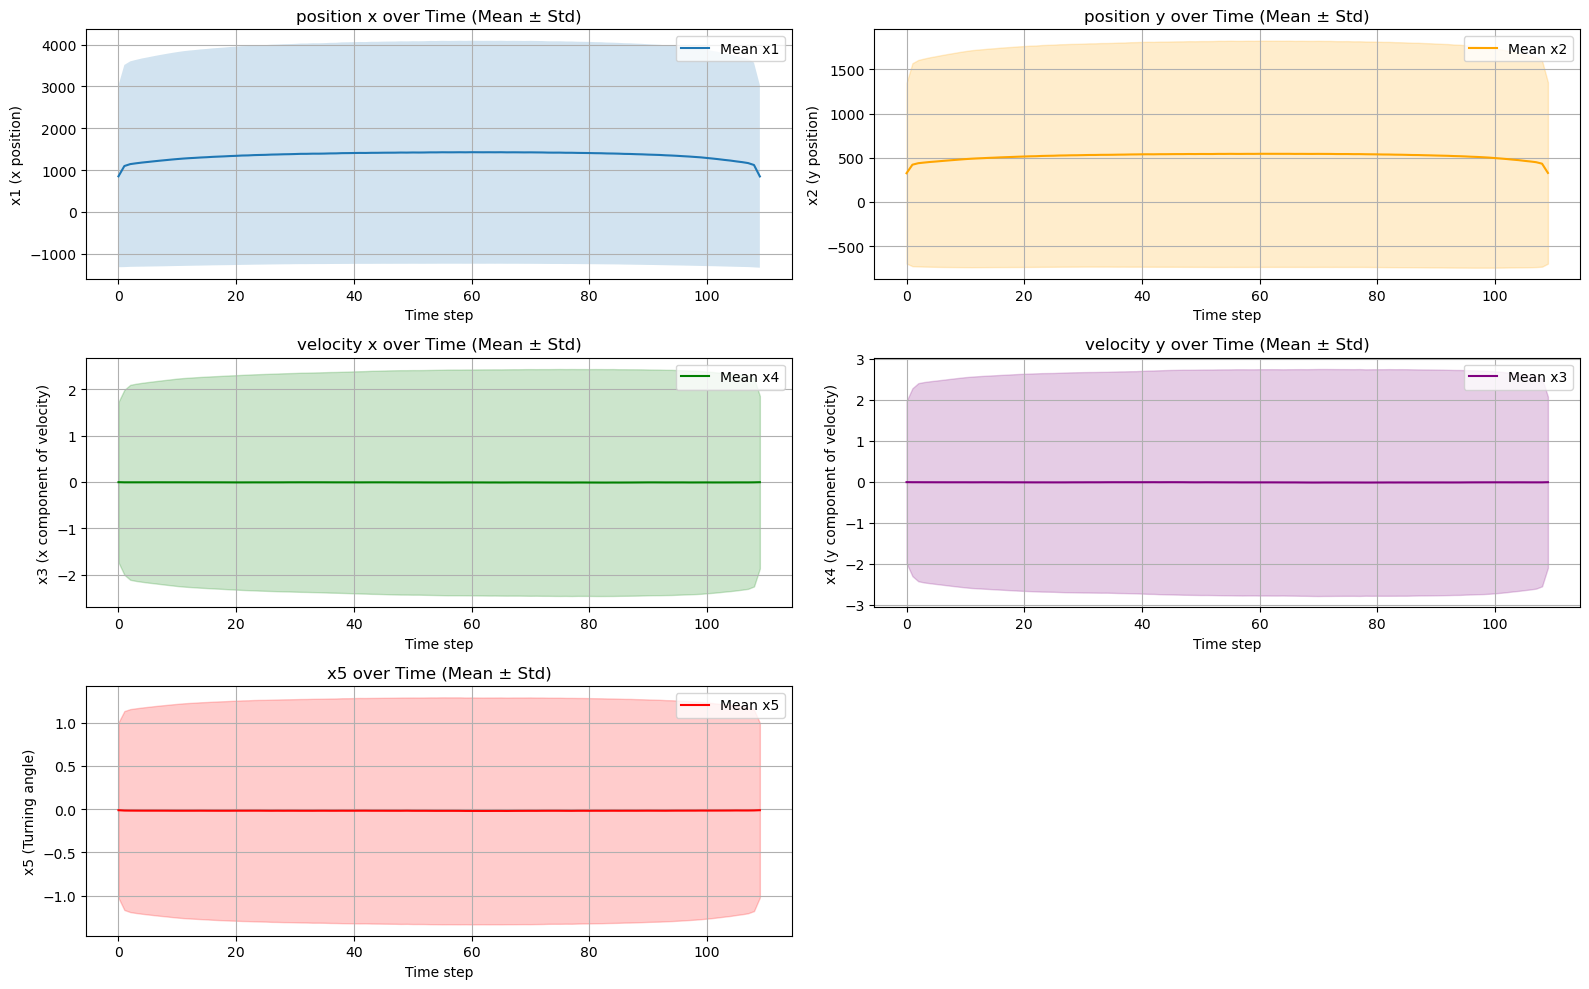

In [10]:
data = trainData
# Assuming data is already loaded and shaped correctly
samples, agents, timesteps, features = data.shape

# Reshape to aggregate across all (samples × agents)
flat_data = data.reshape(-1, timesteps, features)  # shape: (samples*agents, 110, 6)

# Compute mean and std
x1_mean = flat_data[:, :, 0].mean(axis=0)
x1_std = flat_data[:, :, 0].std(axis=0)

x2_mean = flat_data[:, :, 1].mean(axis=0)
x2_std = flat_data[:, :, 1].std(axis=0)

x3_mean = flat_data[:, :, 2].mean(axis=0)
x3_std = flat_data[:, :, 2].std(axis=0)

x4_mean = flat_data[:, :, 3].mean(axis=0)
x4_std = flat_data[:, :, 3].std(axis=0)

x5_mean = flat_data[:, :, 4].mean(axis=0)
x5_std = flat_data[:, :, 4].std(axis=0)

time = np.arange(timesteps)

# Set up figure with GridSpec: 2 rows (2x2 for time-series) + 1 full row for scatter
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2)

# Time-series subplots (2x2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, x1_mean, label='Mean x1')
ax1.fill_between(time, x1_mean - x1_std, x1_mean + x1_std, alpha=0.2)
ax1.set_title("position x over Time (Mean ± Std)")
ax1.set_xlabel("Time step")
ax1.set_ylabel("x1 (x position)")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, x2_mean, label='Mean x2', color='orange')
ax2.fill_between(time, x2_mean - x2_std, x2_mean + x2_std, alpha=0.2, color='orange')
ax2.set_title("position y over Time (Mean ± Std)")
ax2.set_xlabel("Time step")
ax2.set_ylabel("x2 (y position)")
ax2.grid(True)
ax2.legend()

ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time, x4_mean, label='Mean x4', color='green')
ax3.fill_between(time, x4_mean - x4_std, x4_mean + x4_std, alpha=0.2, color='green')
ax3.set_title("velocity x over Time (Mean ± Std)")
ax3.set_xlabel("Time step")
ax3.set_ylabel("x3 (x component of velocity)")
ax3.grid(True)
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(time, x3_mean, label='Mean x3', color='purple')
ax4.fill_between(time, x3_mean - x3_std, x3_mean + x3_std, alpha=0.2, color='purple')
ax4.set_title("velocity y over Time (Mean ± Std)")
ax4.set_xlabel("Time step")
ax4.set_ylabel("x4 (y component of velocity)")
ax4.grid(True)
ax4.legend()


ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(time, x5_mean, label='Mean x5', color='red')
ax5.fill_between(time, x5_mean - x5_std, x5_mean + x5_std, alpha=0.2, color='red')
ax5.set_title("x5 over Time (Mean ± Std)")
ax5.set_xlabel("Time step")
ax5.set_ylabel("x5 (Turning angle)")
ax5.grid(True)
ax5.legend()


plt.tight_layout()
plt.show()


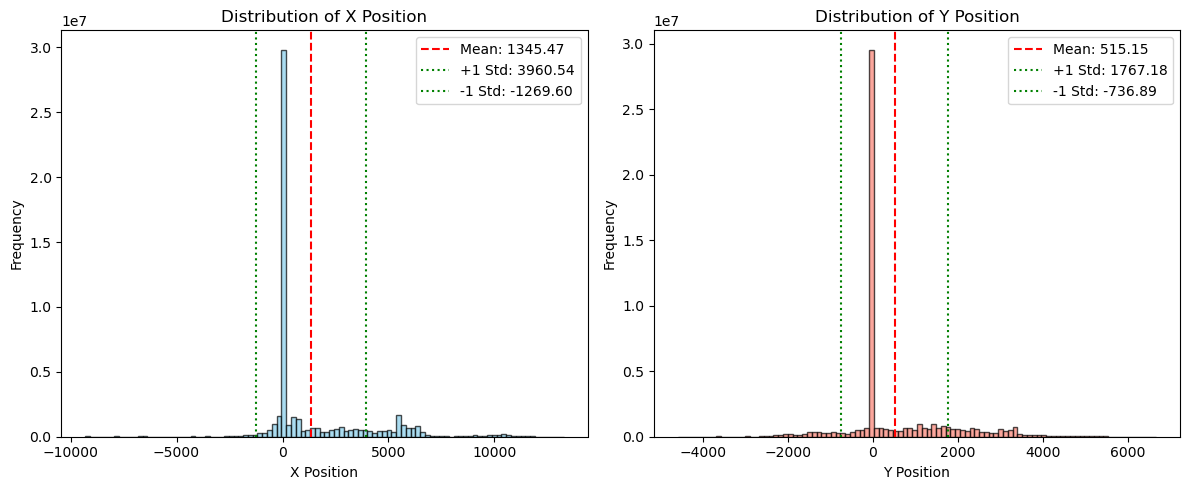

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten training data across all axes except feature
flat_data = trainData.reshape(-1, 6)

# Extract position x and y
x_positions = flat_data[:, 0]
y_positions = flat_data[:, 1]

# Compute mean and std
x_mean, x_std = x_positions.mean(), x_positions.std()
y_mean, y_std = y_positions.mean(), y_positions.std()

# Plot histograms
plt.figure(figsize=(12, 5))

# Position X
plt.subplot(1, 2, 1)
plt.hist(x_positions, bins=100, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(x_mean, color='r', linestyle='--', label=f'Mean: {x_mean:.2f}')
plt.axvline(x_mean + x_std, color='g', linestyle=':', label=f'+1 Std: {x_mean + x_std:.2f}')
plt.axvline(x_mean - x_std, color='g', linestyle=':', label=f'-1 Std: {x_mean - x_std:.2f}')
plt.title("Distribution of X Position")
plt.xlabel("X Position")
plt.ylabel("Frequency")
plt.legend()

# Position Y
plt.subplot(1, 2, 2)
plt.hist(y_positions, bins=100, alpha=0.7, color='salmon', edgecolor='k')
plt.axvline(y_mean, color='r', linestyle='--', label=f'Mean: {y_mean:.2f}')
plt.axvline(y_mean + y_std, color='g', linestyle=':', label=f'+1 Std: {y_mean + y_std:.2f}')
plt.axvline(y_mean - y_std, color='g', linestyle=':', label=f'-1 Std: {y_mean - y_std:.2f}')
plt.title("Distribution of Y Position")
plt.xlabel("Y Position")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
data = trainData
samples, agents, timesteps, features = data.shape

flat_data = data.reshape(-1, timesteps, features)  

x1_mean = flat_data[:, :, 0].mean(axis=0)
x1_std = flat_data[:, :, 0].std(axis=0)

x2_mean = flat_data[:, :, 1].mean(axis=0)
x2_std = flat_data[:, :, 1].std(axis=0)


In [10]:
def normalizeData(train, test, mean_x, std_x, mean_y, std_y):
    norm_train = train.copy()
    norm_test = test.copy()

    norm_train[..., 0] = (train[..., 0] - mean_x) / std_x
    norm_train[..., 1] = (train[..., 1] - mean_y) / std_y

    norm_test[..., 0] = (test[..., 0] - mean_x[:50]) / std_x[:50]
    norm_test[..., 1] = (test[..., 1] - mean_y[:50]) / std_y[:50]

    return norm_train, norm_test

# Normalize the data
normalizedtrain, normalizedtest = normalizeData(trainData, testData,
                                                x1_mean, x1_std,
                                                x2_mean, x2_std,)
normalizedtrain.shape, normalizedtest.shape

((10000, 50, 110, 6), (2100, 50, 50, 6))

In [11]:
class WindowedNormalizedDataset(Dataset):
    def __init__(self, data, window_size, forecast_horizon):
        self.data = data  # shape: (samples, features, timesteps, channels)
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon

        # Precompute indices of valid (sample, t) combinations
        self.indices = []
        for sample in range(data.shape[0]):
            for t in range(data.shape[2] - window_size - forecast_horizon + 1):
                self.indices.append((sample, t))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, t = self.indices[idx]

        x = self.data[sample_idx, :, t:t+self.window_size, :]
        y = self.data[sample_idx, 0, t+self.window_size:t+self.window_size+self.forecast_horizon, :2]
        # print(x.shape, y.shape)
       
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# dataset = WindowedNormalizedDataset(data = trainData, window_size=50, forecast_horizon=60)
traindataset = WindowedNormalizedDataset(data = normalizedtrain, window_size=50, forecast_horizon=60)
# testdataset = WindowedNormalizedDataset(data = normalizedtrain[9000:], window_size=50, forecast_horizon=60)
# dataset.__getitem__(0)

In [12]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, infeatures, outfeatures=2):
        super().__init__()
        # Encoder
        self.layer1 = nn.Linear(infeatures, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.encoderlstm = nn.LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
        
        # Changed pooling target from 20 to 60
        self.pool = nn.AdaptiveAvgPool1d(60)
        self.dropout = nn.Dropout(0.2)
        
        # Decoder
        self.decoderlstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3)
        self.layer10 = nn.Linear(128, 64)
        self.layer11 = nn.Linear(64, 32)
        self.layer12 = nn.Linear(32, outfeatures)
        
        # Skip connections
        self.skip1 = nn.Linear(32, 32)
        self.skip2 = nn.Linear(64, 64)
        self.skip3 = nn.Linear(128, 128)
        self.skip4 = nn.Linear(256, 256)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        
        # Encoder
        out1 = nn.ReLU()(self.layer1(x))
        out2 = nn.ReLU()(self.layer2(out1))
        out3 = nn.ReLU()(self.layer3(out2))
        
        # LSTM processing
        tempout3 = out3.view(batch_size, -1, out3.size(-1))
        out4, _ = self.encoderlstm(tempout3)
        
        # Changed pooling to 60
        tempout4 = self.pool(out4.permute(0, 2, 1))
        tempout4 = tempout4.permute(0, 2, 1)
        lstmskip = tempout4 + self.skip4(tempout4)
        
        # Decoder LSTM
        out5, _ = self.decoderlstm(lstmskip)
        
        out3_reduced = F.adaptive_avg_pool2d(out3.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip1 = out3_reduced + self.skip3(out5)
        out6 = nn.ReLU()(self.layer10(mlpskip1))
        
        out2_reduced = F.adaptive_avg_pool2d(out2.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip2 = out2_reduced + self.skip2(out6)
        out7 = nn.ReLU()(self.layer11(mlpskip2))
        
        out1_reduced = F.adaptive_avg_pool2d(out1.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip3 = out1_reduced + self.skip1(out7)
        out8 = self.layer12(mlpskip3)
        
        return out8

# Verify the output shape
def xavier_init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
        
model = EncoderDecoderModel(6, 2)
model.apply(xavier_init_weights)

# test = torch.randn(128, 50, 50, 6)
# out = model(test)
# print(out.shape)  # Should output torch.Size([128, 60, 2])
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 1359906


In [13]:
# trainDataset = LargeDataset(a, b, train_mean, train_std) # testing for small dataset a, b
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# model.load_state_dict(torch.load("./models/modelF/medium_model_92_0.0012164336.pth"))  

trainDataLoader = DataLoader(traindataset, batch_size=128, shuffle=True, num_workers=0)
# testDataLoader = DataLoader(testdataset, batch_size=128)
model.to(device)
# print(len(trainDataLoader))
# Training setup
epochs = 1000
lossFn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Iused 0.0008, 0.0001

log_loss_path = "./models/modelG/log_loss.txt"
for each_epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(trainDataLoader, desc=f"Epoch [{each_epoch+1}/{epochs}]")

    for batchX, batchY in loop:
        batchX, batchY = batchX.to(device, non_blocking=True), batchY.to(device, non_blocking=True)
        output = model(batchX)
        # print(output.shape, batchY.shape)
        # break
        loss = lossFn(output, batchY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    # break
    avgLoss = runningLoss / len(trainDataLoader)

    # model.eval()
    # with torch.inference_mode():
    #     testloss = 0.0
    #     for testX, testY in testDataLoader:
    #         testX, testY = testX.to(device, non_blocking=True), testY.to(device, non_blocking=True)
    #         pred = model(testX)
    #         tloss = lossFn(pred, testY)
    #         testloss += tloss.item()

    #     avgtestloss = testloss/len(testDataLoader)
        # if each_epoch % 5 == 0 or each_epoch+1 >= epochs:
    print(f"Epoch {each_epoch + 1}, Training Loss: {avgLoss:.10f} ")
    with open(log_loss_path, 'a') as f:
        f.write(f"{each_epoch + 1},{avgLoss:.10f},\n")
        
    torch.save(model.state_dict(), f'./models/modelG/medium_model_{each_epoch+1}_{avgLoss:.10f}.pth')
    torch.cuda.empty_cache()
    scheduler.step()


Epoch [1/1000]:   0%|          | 0/79 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [43]:
# model.load_state_dict(torch.load("./models/modelF/medium_model_1044882.981013.pth"))  
test1 = torch.tensor(testData[0], dtype = torch.float).to(device)
test1.to(device)
pred = model(test1.unsqueeze(0))

In [18]:
print(x1_mean.shape, x1_std.shape, x2_mean.shape, x2_std.shape)

(110,) (110,) (110,) (110,)


In [20]:
x1_mean[:50].shape, x1_mean[50:].shape

((50,), (60,))

In [28]:
def createSubmission(modelPath, submissionFileName):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(modelPath, map_location=device))  
    test_data = torch.tensor(normalizedtest, dtype=torch.float32)
    rows = []
    for i in range(test_data.shape[0]):
        pred = model(test_data[i].unsqueeze(0))
        # pred[:, :, :]
        # print(pred.shape)
        # print(pred[0, 0, :])
        # print(pred.shape)
        items = pred.squeeze(0).tolist()
        j = 50
        for idx, (x, y) in enumerate(items):
            x = (x * x1_std[j]) + x1_mean[j]
            y = (y * x2_std[j]) + x2_mean[j]
            rows.append({'x': x, 'y': y})
            j += 1
    df = pd.DataFrame(rows)
    df.index.name = 'index'
    df.to_csv('./submission/'+submissionFileName)


createSubmission("./models/medium_model_37_0.0161520632.pth", "test16.csv")

In [31]:
testData[0,0, :, :2]


array([[5426.16006774, 1467.4815507 ],
       [5426.28135379, 1467.52708934],
       [5426.31836785, 1467.53746055],
       [5426.28846383, 1467.51249604],
       [5426.28216581, 1467.51902199],
       [5426.33025932, 1467.5518653 ],
       [5426.34332959, 1467.55620041],
       [5426.28434098, 1467.51861295],
       [5426.24232676, 1467.48959082],
       [5426.18871283, 1467.50617355],
       [5426.24124094, 1467.55110122],
       [5426.22984693, 1467.51679755],
       [5426.23381547, 1467.51246435],
       [5426.26662458, 1467.51379165],
       [5426.24757982, 1467.49105768],
       [5426.20151553, 1467.49663228],
       [5426.25018437, 1467.55939368],
       [5426.30490546, 1467.57089141],
       [5426.27427858, 1467.50389855],
       [5426.15460794, 1467.3828348 ],
       [5426.15615182, 1467.42129297],
       [5426.23614149, 1467.5041364 ],
       [5426.31621766, 1467.53622433],
       [5426.2897965 , 1467.51738571],
       [5426.26998553, 1467.4806786 ],
       [5426.30820146, 14

In [ ]:
testData[1,0, :, :2]

array([[3054.52520103, 1765.11983755],
       [3054.73186291, 1765.28829318],
       [3054.95884129, 1765.49534969],
       [3055.24560608, 1765.76459885],
       [3055.58212908, 1766.08013141],
       [3055.92676493, 1766.39146873],
       [3056.29066084, 1766.72148759],
       [3056.65339685, 1767.06250587],
       [3057.00831393, 1767.41986976],
       [3057.37809389, 1767.78200688],
       [3057.80043487, 1768.14291346],
       [3058.14639559, 1768.4602628 ],
       [3058.51926468, 1768.80196275],
       [3058.86303452, 1769.10560864],
       [3059.12321939, 1769.33909072],
       [3059.40122153, 1769.62565118],
       [3059.74401491, 1769.98178327],
       [3060.10286226, 1770.28706555],
       [3060.37975662, 1770.52325853],
       [3060.59500824, 1770.72600841],
       [3060.86175347, 1771.00232815],
       [3061.13426523, 1771.28759782],
       [3061.40123121, 1771.53814511],
       [3061.59564237, 1771.72882902],
       [3061.79435989, 1771.90906535],
       [3062.04103056, 17